In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
import pandas as pd
import datetime
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import make_interp_spline

In [2]:
xr.set_options(display_style='text')

In [289]:
# iclassdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/'
iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/CSAPR2_Taranis_Gridded_500m.Terrain_RangeMask.nc'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2.nc'
stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
sat_file = f'{statsdir}/stats_goes16_20181015.0000_20190303.0000.nc'
sonde_file = f'{statsdir}/interpsonde_parameters_celltrack_20181015.0000_20190303.0000.nc'

radar_lat = -32.1264
radar_lon = -64.7284

# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/'
figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/area_growthrate_cases/'

In [5]:
# Read 2D track data
stats2d = xr.open_dataset(stats_file)
time_res = stats2d.attrs['time_resolution_hour']
pixel_radius = stats2d.attrs['pixel_radius_km']
stats2d.dims['tracks']

6895

In [6]:
# Read sonde data
sonde = xr.open_dataset(sonde_file)
sonde.dims['tracks']

6895

In [7]:
# Read satellite data
sat = xr.open_dataset(sat_file, drop_variables=['basetime', 'cell_area'])
sat.dims['tracks']

6895

In [8]:
# Combine datasets by coordinates
stats = xr.combine_by_coords([stats2d, sat, sonde], combine_attrs='override')
stats.load()
print(stats)

<xarray.Dataset>
Dimensions:                      (reltime: 4, times: 60, tracks: 6895)
Coordinates:
  * tracks                       (tracks) int32 0 1 2 3 ... 6891 6892 6893 6894
  * reltime                      (reltime) int32 0 -1 -2 -3
  * times                        (times) int32 0 1 2 3 4 5 ... 54 55 56 57 58 59
Data variables: (12/285)
    time                         (tracks, reltime) datetime64[ns] 2018-10-16T...
    tallenough_sfc               (tracks, reltime) float32 1.0 1.0 ... 1.0 1.0
    CAPE_sfc                     (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_sfc                   (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_fract_sfc             (tracks, reltime) float32 nan nan ... nan nan
    CIN_IB_sfc                   (tracks, reltime) float32 -9.999e+03 ... -9....
    ...                           ...
    end_merge_timeindex          (tracks) float64 nan nan nan ... 1.0 nan nan
    end_merge_cloudnumber        (tracks) float64 nan nan n

In [9]:
# time_res = stats.attrs['time_resolution_hour']
tracks = stats.tracks
times = stats.times

xtimes = times * time_res
xtimes

# lifetime = stats['lifetime'] * time_res
# start_time = stats['start_basetime']
# end_time = stats['end_basetime']
# end_merge_tracknumber = stats['end_merge_tracknumber']
# start_split_tracknumber = stats['start_split_tracknumber']
# cell_lon = stats['cell_meanlon']
# cell_lat = stats['cell_meanlat']
# cell_area = stats['cell_area']
# maxrange_flag = stats['maxrange_flag']
# status = stats['status']

# eth10 = stats['maxETH_10dbz']
# eth20 = stats['maxETH_20dbz']
# eth30 = stats['maxETH_30dbz']
# eth40 = stats['maxETH_40dbz']
# eth50 = stats['maxETH_50dbz']

<xarray.DataArray 'times' (times: 60)>
array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75])
Coordinates:
  * times    (times) int32 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59

In [10]:
start_datetime = '2019-01-25T17'
end_datetime = '2019-01-26T00'

# Find track indices that initiate within the input datetime window
idx = np.where((stats.start_basetime.values >= np.datetime64(start_datetime)) & (stats.start_basetime.values <= np.datetime64(end_datetime)))[0]

start_time = stats.start_basetime.isel(tracks=idx)
duration = stats.lifetime.isel(tracks=idx)
lifetime = duration * time_res
cell_lon = stats.cell_meanlon.isel(tracks=idx)
cell_lat = stats.cell_meanlat.isel(tracks=idx)
cell_area = stats.cell_area.isel(tracks=idx)
eth30 = stats.maxETH_30dbz.isel(tracks=idx)
eth40 = stats.maxETH_40dbz.isel(tracks=idx)
start_split_tracknumber = stats.start_split_tracknumber.isel(tracks=idx)
end_merge_tracknumber = stats.end_merge_tracknumber.isel(tracks=idx)
status = stats.status.isel(tracks=idx)
ctt = stats.cloud_top_temperature_min.isel(tracks=idx) - 273.15

In [11]:
stats.times * time_res

<xarray.DataArray 'times' (times: 60)>
array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75])
Coordinates:
  * times    (times) int32 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59

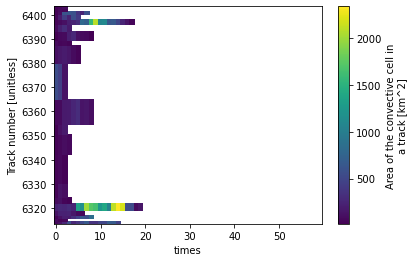

In [12]:
cell_area.where(lifetime > 0.5, drop=True).plot()

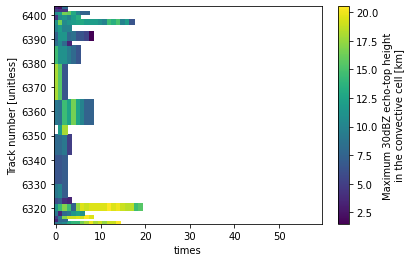

In [13]:
eth30.where(lifetime > 0.5, drop=True).plot()

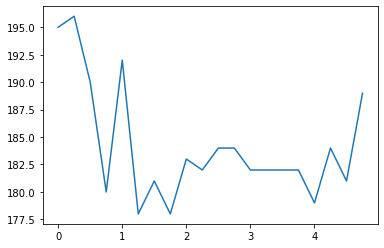

In [14]:
tracknum = 6320
# imucape = stats.CAPE_mu.sel(tracks=6314, reltime=0).values
# ilifetime = stats.lifetime.sel(tracks=6314).values * time_res
# itime0 = stats.basetime.sel(tracks=tracknum, times=0).dt.strftime('%H:%M').values
# stats.maxdbz.sel(tracks=tracknum).max(dim='times')
# stats.shear_mag_bulk_0to6km.sel(tracks=tracknum, reltime=0).values
plt.plot(xtimes, stats.cloud_top_temperature_min.sel(tracks=tracknum))
# plt.plot(xtimes, stats.cloud_top_height_max.sel(tracks=tracknum))
# plt.ylabel('Max CTH (km)')
# plt.xlabel('Hour since track')

In [15]:
stats.status.sel(tracks=6314)

<xarray.DataArray 'status' (times: 60)>
array([ 1.,  1.,  1., 13.,  4.,  1.,  1., 13.,  4.,  1.,  1.,  1., 13.,
       16., 37., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    tracks   int32 6314
  * times    (times) int32 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
Attributes:
    long_name:  Flag indicating evolution / behavior for each cloud in a track
    units:      unitless
    valid_min:  0
    valid_max:  65
    comments:   0: Track stops;  1: Simple track continuation;  2: This is th...

In [16]:
stats.status.sel(tracks=tracknum).attrs['comments']

'0: Track stops;  1: Simple track continuation;  2: This is the bigger cloud in simple merger;  3: This is the bigger cloud from a simple split that stops at this time;  4: This is the bigger cloud from a split and this cloud continues to the next time;  5: This is the bigger cloud from a split that subsequently is the big cloud in a merger;  13: This cloud splits at the next time step;  15: This cloud is the bigger cloud in a merge that then splits at the next time step;  16: This is the bigger cloud in a split that then splits at the next time step;  18: Merge-split at same time (big merge, splitter, and big split);  21: This is the smaller cloud in a simple merger;  24: This is the bigger cloud of a split that is then the small cloud in a merger;  31: This is the smaller cloud in a simple split that stops;  32: This is a small split that continues onto the next time step;  33: This is a small split that then is the bigger cloud in a merger;  34: This is the small cloud in a merger t

In [17]:
istats = stats.status.sel(tracks=6320)
istats
# tidx_split = np.where(istats == 4)[0]
# plt.plot(xtimes[tidx_split], icell_area[tidx_split], 'o')

<xarray.DataArray 'status' (times: 60)>
array([32.,  1., 13.,  5., 15., 18., 18., 18.,  4., 13., 18., 18.,  5.,
       15., 18., 18., 18.,  4.,  1.,  0., nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    tracks   int32 6320
  * times    (times) int32 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
Attributes:
    long_name:  Flag indicating evolution / behavior for each cloud in a track
    units:      unitless
    valid_min:  0
    valid_max:  65
    comments:   0: Track stops;  1: Simple track continuation;  2: This is th...

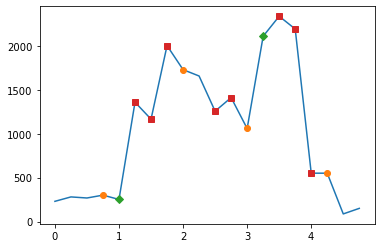

In [18]:
icell_area = stats.cell_area.sel(tracks=6320)
istats = stats.status.sel(tracks=6320)
tidx_split = np.where((istats == 4) | (istats == 5) | (istats == 16))[0]
tidx_merge = np.where((istats == 2) | (istats == 15) | (istats == 37))[0]
tidx_mergesplit = np.where((istats == 18) | (istats == 46))[0]
plt.plot(xtimes, icell_area)
plt.plot(xtimes[tidx_split], icell_area[tidx_split], 'o')
plt.plot(xtimes[tidx_merge], icell_area[tidx_merge], 'D')
plt.plot(xtimes[tidx_mergesplit], icell_area[tidx_mergesplit], 's')

In [19]:
tracknum = 6321
icell_area = stats.cell_area.sel(tracks=tracknum)
iduration = stats.lifetime.sel(tracks=tracknum).values
print(iduration)

# idx = icell_area.values > 0
# xx = xtimes.values[idx]
# yy = icell_area.values[idx]

# b, a = signal.butter(1, 0.4, analog=False)
# yy_s = signal.filtfilt(b, a, yy)

# plt.plot(xx, yy, 'o-', color='k')
# plt.plot(xx, yy_s, 'o-', color='b')

2.0


In [214]:
def get_layer_boundary(idx, gap, min_thick):
    """
    Get contiguous layer boundary indices.
    ----------
    idx: np.array(int)
        Indices of points.
    gap: int
        If a gap larger than this exists, they are separated into different layers
    min_thick: int
        Minimum thickness of a layer.

    Returns
    ----------
    layer_start: np.ndarray(nLayers)
        Start index for each layer.
    layer_end: np.ndarray(nLayers)
        End index for each layer.
    """

    # Split idx into layers
    Layers = np.split(idx, np.where(np.diff(idx) > gap)[0]+1)
    nLayers = len(Layers)

    # Create layer_start, layer_end arrays
    layer_start = np.full(nLayers, -99, dtype=int)
    layer_end = np.full(nLayers, -99, dtype=int)

    if nLayers > 0:
        # Loop over each layer
        for iLayer in range(0, nLayers):

            # Calculate layer thickness
            zb = Layers[iLayer][0]
            zt = Layers[iLayer][-1]
            dz = zt - zb
            # A layer must be thicker than min_thick here:
            if (dz > min_thick):
                layer_start[iLayer] = zb
                layer_end[iLayer] = zt
        
        # Exclude negative (i.e., thickness <= min_thick)
        layer_start = layer_start[layer_start >= 0]
        layer_end = layer_end[layer_end >= 0]

    return layer_start, layer_end

In [215]:
def get_growth_rate1(x_in, y_in, duration, Wn):
    idx = y_in > 0
    x = x_in[idx]
    y = y_in[idx]
    
    # Set up number of interpolated samples
    ns_interp = (duration*4).astype(int)

    # Perform spline fitting interpolation
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), ns_interp)
    Y_ = X_Y_Spline(X_)

    # Perform low-pass filter
    b, a = signal.butter(1, Wn, analog=False)
    Y_s = signal.filtfilt(b, a, Y_)

    # Calculate area growth/decay rate (km2/hour)
    dY = np.diff(Y_s) / np.diff(X_)
    
    return (X_, Y_, Y_s, dY)

In [216]:
def get_growth_rate2(x_in, y_in, duration, Wn):
    idx = y_in > 0
    x = x_in[idx]
    y = y_in[idx]
    
    # Set up number of interpolated samples
    ns_interp = (duration*4).astype(int)
    
    # Perform low-pass filter
    b, a = signal.butter(1, Wn, analog=False)
    y_s = signal.filtfilt(b, a, y)

    # Perform spline fitting interpolation
    X_Y_Spline = make_interp_spline(x, y_s)
    X_ = np.linspace(x.min(), x.max(), ns_interp)
    Y_ = X_Y_Spline(X_)

    # Calculate area growth/decay rate (km2/hour)
    dY = np.diff(Y_) / np.diff(X_)
    
    return (X_, Y_, y_s, dY)

In [352]:
def define_growth_stage(X, dY, min_rate_percent, gap=1, min_dur=0):
    
    growth_flag = np.zeros(len(dY), dtype=int)
    
    # Get the percentile for positive area change rate
    # dY_thres = np.quantile(dY[dY > 0], min_rate_percent)
    
    # Get the percentile for absolute area change rate
    dY_thres = np.quantile(np.abs(dY), min_rate_percent)
    
    # Get positive dY indices
    idx_p = np.where(dY > dY_thres)[0]
    # Get negative dY indices
    idx_n = np.where(dY < dY_thres)[0]
    
    # Proceed if there is sufficient sample to define layers
    if (len(idx_p) > min_dur) & (len(idx_n) > min_dur):
        # Get growth period indices
        gidx_s, gidx_e = get_layer_boundary(idx_p, gap, min_dur)
        g_dur = gidx_e - gidx_s    
        # Get decay period indices
        didx_s, didx_e = get_layer_boundary(idx_n, gap, min_dur)
        d_dur = didx_e - didx_s

        # print('Growth:', gidx_s)
        # print('Decay:', didx_s)
        # Combine growth and decayse period start/end indices, and sort them
        idx_s = np.sort(np.concatenate((gidx_s, didx_s)))
        idx_e = np.sort(np.concatenate((gidx_e, didx_e)))
        # print('Combine:', idx_s)
        # Find growth indices in the combine index array
        junk, g1, junk = np.intersect1d(idx_s, gidx_s, return_indices=True)
        junk, d1, junk = np.intersect1d(idx_s, didx_s, return_indices=True)
        # print('Match growth index:', g1)
        # print('Match decay index:', d1)
        # Set growth period to 1, decay period to -1
        stages = np.zeros(len(idx_s), dtype=int)
        stages[g1] = 1
        stages[d1] = -1
        # print('Stages:', stages)

        # Proceed if first stage is growth
        if stages[0] == 1:
            # Set periods of first stage to 1
            growth_flag[idx_s[0]:idx_e[0]] = 1

            # Compute stage differences
            stage_diff = np.diff(stages)
            # print(stage_diff)
            # Find indices of consecutive growth/decay stages (diff==0)
            idx_consec = np.where(stage_diff == 0)[0]
            if len(idx_consec) > 0:
                # Loop over each consecutive stage
                for p in range(len(idx_consec)):
                    idxp = idx_consec[p]
                    # For the first stage
                    if idxp == 0:
                        # If it is a growth stage, set the next stage flag as growth
                        if stages[idxp] == 1:
                            growth_flag[idx_s[idxp+1]:idx_e[idxp+1]] = 1
                    # For subsequent stages
                    else:
                        # If both previous and current stage are growth, 
                        # set the next stage flag as growth
                        if (stages[idxp-1] == 1) & (stages[idxp] == 1):
                            growth_flag[idx_s[idxp+1]:idx_e[idxp+1]] = 1
    
    return growth_flag, dY_thres

In [351]:
stages[idx_consec-1]

array([-1])

In [355]:
tidx = np.where(stats.lifetime == 8)[0]
cell_area = stats.cell_area.sel(tracks=tidx)
duration = stats.lifetime.sel(tracks=tidx)
tracks = cell_area.tracks.values
# print(f'Number of tracks: {len(tidx)}')

gap = 1
min_dur = 1

tracknum_consecstages = []
for tracknum in tracks:
# for tracknum in [5944]:
    # print(tracknum)
    icell_area = cell_area.sel(tracks=tracknum)
    iduration = duration.sel(tracks=tracknum).values
    # # Set up number of interpolated samples
    # ns_interp = (iduration*4).astype(int)

    idx = icell_area.values > 0
    x = xtimes.values[idx]
    y = icell_area.values[idx]

    # Fit then then low-pass filter
    Wn1 = 0.2
    min_rate_percent = 0.1
    X1, Y1, Ys1, dY1 = get_growth_rate1(x, y, iduration, Wn1)
    # Define growth stage
    growth_flag1, dY_thres1 = define_growth_stage(X1, dY1, min_rate_percent, gap, min_dur)

    # Low-pass filter then fit
    Wn2 = 0.6
    X2, Ys2, ys2, dY2 = get_growth_rate2(x, y, iduration, Wn2)
    # Define growth stage
    growth_flag2, dY_thres2 = define_growth_stage(X2, dY2, min_rate_percent, gap, min_dur)


    # Get positive/negative dY indices
    idx_p = np.where(dY1 > dY_thres1)[0]
    idx_n = np.where(dY1 < dY_thres1)[0]
    # idx_p = np.where(dY2 > dY_thres2)[0]
    # idx_n = np.where(dY2 < dY_thres2)[0]
    # Get growth period indices
    gidx_s, gidx_e = get_layer_boundary(idx_p, gap, min_dur)
    g_dur = gidx_e - gidx_s    
    # Get decay period indices
    didx_s, didx_e = get_layer_boundary(idx_n, gap, min_dur)
    d_dur = didx_e - didx_s

    # print('Growth:', gidx_s)
    # print('Decay:', didx_s)
    # Combine growth and decayse period start indices, and sort them
    idx_s = np.sort(np.concatenate((gidx_s, didx_s)))
    # print('Combine:', idx_s)
    # Find growth indices in the combine index array
    junk, g1, junk = np.intersect1d(idx_s, gidx_s, return_indices=True)
    junk, d1, junk = np.intersect1d(idx_s, didx_s, return_indices=True)
    # print('Match growth index:', g1)
    # print('Match decay index:', d1)

    stages = np.zeros(len(idx_s), dtype=int)
    stages[g1] = 1
    stages[d1] = -1
    # Compute stage differences
    stage_diff = np.diff(stages)
    # print(stages)
    # print(stage_diff)
    # Find indices of consecutive growth/decay stages (diff==0)
    idx_consec = np.where(stage_diff == 0)[0]
    # print(idx_consec)
    
    # Finds tracks that has consecutive stages and keep their tracknumbers
    if len(idx_consec) > 0:
        print(tracknum)
        tracknum_consecstages.append(tracknum)

175
423
441
714
725
962
1225
1510
1788
2361
2731
3038
3105
3200
3499
3556
3909
4450
5425
5944
6159
6272
6287
6796


In [367]:
lifetime_ = stats.where(stats.lifetime == 8, drop=True).tracks
lifetime_.tracks

<xarray.DataArray 'tracks' (tracks: 118)>
array([  57,  164,  175,  195,  382,  385,  423,  441,  444,  569,  652,  714,
        725,  733,  743,  825,  890,  914,  962, 1061, 1087, 1128, 1147, 1225,
       1229, 1275, 1277, 1348, 1483, 1510, 1511, 1542, 1553, 1674, 1682, 1742,
       1747, 1788, 1918, 1921, 1932, 1992, 2003, 2018, 2021, 2071, 2128, 2159,
       2201, 2232, 2361, 2412, 2425, 2441, 2443, 2445, 2540, 2574, 2575, 2621,
       2695, 2731, 2757, 2791, 2797, 2822, 2846, 2923, 2939, 2946, 3038, 3063,
       3102, 3105, 3200, 3230, 3402, 3433, 3462, 3499, 3556, 3574, 3649, 3909,
       3948, 3970, 4002, 4029, 4186, 4450, 4614, 4665, 4712, 5037, 5080, 5124,
       5257, 5340, 5425, 5468, 5491, 5495, 5609, 5730, 5790, 5940, 5944, 5998,
       6048, 6159, 6200, 6272, 6287, 6401, 6506, 6767, 6796, 6806], dtype=int32)
Coordinates:
  * tracks   (tracks) int32 57 164 175 195 382 385 ... 6401 6506 6767 6796 6806
Attributes:
    long_name:  Track number
    units:      unitless

Number of long-lived tracks: 118
/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/area_growthrate_cases/area_growthrate_track1510.png


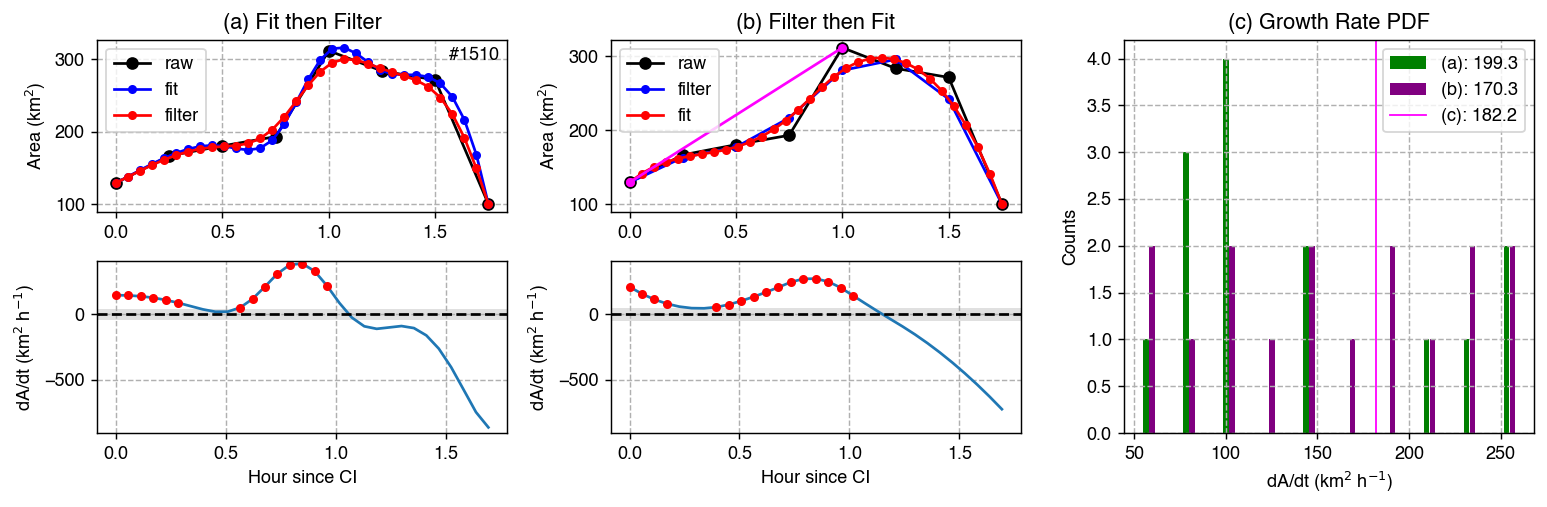

In [381]:
gap = 1
min_dur = 1
min_rate_percent = 0.1

# tidx = np.where(stats.lifetime == 7)[0]
lifetime_ = stats.where(stats.lifetime == 8, drop=True).tracks
tracknum = lifetime_.tracks.values
ntracks = len(tracknum)
print(f'Number of long-lived tracks: {ntracks}')

cell_area = stats.cell_area.sel(tracks=tracknum)
duration = stats.lifetime.sel(tracks=tracknum)
# print(f'Number of tracks: {len(tidx)}')

for tracknum in [1510]:
# for tracknum in tracknum_consecstages:
    icell_area = cell_area.sel(tracks=tracknum)
    iduration = duration.sel(tracks=tracknum).values
    # # Set up number of interpolated samples
    # ns_interp = (iduration*4).astype(int)

    idx = icell_area.values > 0
    x = xtimes.values[idx]
    y = icell_area.values[idx]

    # Fit then then low-pass filter
    Wn1 = 0.2
    X1, Y1, Ys1, dY1 = get_growth_rate1(x, y, iduration, Wn1)
    # Define growth stage
    growth_flag1, dY_thres1 = define_growth_stage(X1, dY1, min_rate_percent, gap, min_dur)
    ns_growth1 = np.count_nonzero(growth_flag1 == 1)
    if (ns_growth1 > 1):
        dY_hist1, bins = np.histogram(dY1[growth_flag1 == 1])
        dY_avg1 = np.nanmean(dY1[growth_flag1 == 1])

    # Low-pass filter then fit
    Wn2 = 0.6
    X2, Ys2, ys2, dY2 = get_growth_rate2(x, y, iduration, Wn2)
    # Define growth stage
    growth_flag2, dY_thres2 = define_growth_stage(X2, dY2, min_rate_percent, gap, min_dur)
    ns_growth2 = np.count_nonzero(growth_flag2 == 1)
    if (ns_growth2 > 1):
        dY_hist2, bins = np.histogram(dY2[growth_flag2 == 1])
        dY_avg2 = np.nanmean(dY2[growth_flag2 == 1])
        
    # Simple method: (max_area - CI_area) / duration_to_max_area
    ymax_idx = np.argmax(y)
    if (ymax_idx > 0):
        dY_avg3 = (np.nanmax(y) - y[0]) / (x[ymax_idx] - x[0])

    if (ns_growth1 > 1) & (ns_growth2 > 1):

        mpl.rcParams['font.family'] = 'Helvetica'
        ymin, ymax = np.nanmin([dY1, dY2])*1.05, np.nanmax([dY1, dY2])*1.05
        msize = 4

        fig, axes = plt.subplots(2, 3, figsize=[12,4], dpi=130)
        ax = axes[0,0]
        ax.plot(x, y, 'o-', color='k', label='raw')
        ax.plot(X1, Y1, 'o-', color='b', label='fit', markersize=msize)
        ax.plot(X1, Ys1, 'o-', color='r', label='filter', markersize=msize)
        ax.legend()
        ax.set_ylabel('Area (km$^2$)')
        ax.grid(ls='--')
        ax.set_title('(a) Fit then Filter')
        ax.text(0.98, 0.88, f'#{tracknum}', ha='right', transform=ax.transAxes)

        ax = axes[1,0]
        ax.plot(X1[:-1], dY1)
        ax.plot(X1[:-1][growth_flag1==1], dY1[growth_flag1==1], 'o', color='r', markersize=msize)
        ax.axhspan(-dY_thres1, dY_thres1, facecolor='lightgray', alpha=0.7)
        ax.axhline(0, color='k', ls='--')
        ax.set_ylabel('dA/dt (km$^2$ h$^{-1}$)')
        ax.set_xlabel('Hour since CI')
        ax.set_ylim(ymin, ymax)
        ax.grid(ls='--')
        # ax.axhline(dY_avg1, color='g')

        ax = axes[0,1]
        ax.plot(x, y, 'o-', color='k', label='raw')
        ax.plot(x, ys2, 'o-', color='b', label='filter', markersize=msize)
        ax.plot(X2, Ys2, 'o-', color='r', label='fit', markersize=msize)
        ax.legend()
        ax.set_ylabel('Area (km$^2$)')
        ax.grid(ls='--')
        ax.set_title('(b) Filter then Fit')
        if dY_avg3 > 0:
            ax.plot([x[0],x[ymax_idx]], [y[0],y[ymax_idx]], marker='o', color='magenta', markersize=msize)

        ax = axes[1,1]
        ax.plot(X2[:-1], dY2)
        ax.plot(X2[:-1][growth_flag2==1], dY2[growth_flag2==1], 'o', color='r', markersize=msize)
        ax.axhspan(-dY_thres2, dY_thres2, facecolor='lightgray', alpha=0.7)
        ax.axhline(0, color='k', ls='--')
        ax.set_ylabel('dA/dt (km$^2$ h$^{-1}$)')
        ax.set_xlabel('Hour since CI')
        ax.set_ylim(ymin, ymax)
        ax.grid(ls='--')
        # ax.axhline(dY_avg2, color='purple')
        # if dY_avg3 > 0:
        #     ax.axhline(dY_avg3, color='magenta')

        gs = axes[0,2].get_gridspec()
        for ax in axes[:,-1]:
            ax.remove()
        ax = fig.add_subplot(gs[:,-1])

        ax.bar(bins[:-1], dY_hist1, color='g', width=3, label=f'(a): {dY_avg1:.1f}')
        ax.bar(bins[:-1]+np.mean(np.diff(bins))*0.15, dY_hist2, color='purple', width=3, label=f'(b): {dY_avg2:.1f}')
        ax.axvline(dY_avg3, lw=1, color='magenta', label=f'(c): {dY_avg3:.1f}')
        ax.set_xlabel('dA/dt (km$^2$ h$^{-1}$)')
        ax.set_ylabel('Counts')
        ax.set_title('(c) Growth Rate PDF')
        ax.grid(ls='--')
        # ax.legend()
        #get handles and labels
        handles, labels = plt.gca().get_legend_handles_labels()
        #specify order of items in legend
        order = [1,2,0]
        #add legend to plot
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

        fig.tight_layout()
        figname = f'{figdir}area_growthrate_track{tracknum:04}.png'
        fig.savefig(figname, bbox_inches='tight', dpi=200, facecolor='w')
        print(figname)
        # plt.close(fig)

In [319]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/area_growthrate_cases/'

In [365]:
1.75/0.25

7.0